In [1]:
def rescale_image(image):
    # Calculate the minimum and maximum pixel intensities for rescaling
    percentile_0 = np.percentile(image, 0.35)
    percentile_100 = np.percentile(image, 99.65)

    # Rescale the image
    rescaled_image = np.clip(image, percentile_0, percentile_100)
    rescaled_image = ((rescaled_image - percentile_0) / (percentile_100 - percentile_0)) * 255
    rescaled_image = rescaled_image.astype(np.uint8)

    return rescaled_image

In [2]:
import cv2
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt

def enhance_contrast(image, method='histogram_eq'):
    """
    Enhance the contrast of the image.
    Parameters:
    - image : The input image.
    - method: The contrast enhancing method, can be 'histogram_eq', 'adaptive_histogram_eq', 'contrast_stretching', 'log_transform', 'power_law_transform', 'sigmoid_correction', 'clahe'
    Returns:
    - The contrast enhanced image.
    """

    # Convert image to uint8, necessary for some methods
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    if method == 'histogram_eq':
        return cv2.equalizeHist(image)
    elif method == 'adaptive_histogram_eq':
        return exposure.equalize_adapthist(image, clip_limit=0.03)
    elif method == 'contrast_stretching':
        p2, p98 = np.percentile(image, (2, 98))
        return exposure.rescale_intensity(image, in_range=(p2, p98))
    elif method == 'log_transform':
        c = 255 / np.log(1 + np.max(image))
        log_image = c * (np.log(image + 1))
        return np.array(log_image, dtype=np.uint8)
    elif method == 'power_law_transform':
        gamma = 0.5  # Gamma < 1 decreases the influence of high intensity values
        return np.array(255*(image / 255) ** gamma, dtype = 'uint8')
    elif method == 'sigmoid_correction':
        return exposure.adjust_sigmoid(image)
    elif method == 'clahe':
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        return clahe.apply(image)
    else:
        print("Invalid contrast enhancement method. Choose either 'histogram_eq', 'adaptive_histogram_eq', 'contrast_stretching', 'log_transform', 'power_law_transform', 'sigmoid_correction', or 'clahe'.")
        return image

In [3]:
from skimage import restoration, color
from scipy import ndimage as nd
import numpy as np

def estimate_noise(image):
    """
    Estimate the noise of an image using the MAD method
    """
    # Convert the image to grayscale if it's RGB
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
        
    # Median filter the image
    med = nd.median_filter(image, 5)
    
    # Calculate the absolute difference between the original image and the median image
    mad = np.mean(np.abs(image - med))
    
    return mad

def denoise_image(image, threshold):
    """
    De-noise the image using non-local means, altering h parameter until noise is below threshold.
    """
    # Initial h value
    h = 0.1
    # Increment h value
    increment = 0.1

    # Measure the noise
    noise = estimate_noise(image)
    
    # Return the original image if the noise is already less than the threshold
    if noise < threshold:
        return image

    while noise > threshold:
        denoised = restoration.denoise_nl_means(image, h=h, fast_mode=True)
        noise = estimate_noise(denoised)
        h += increment
        increment *= 2  # Double the increment at each pass

    return denoised

In [52]:
import numpy as np
import cv2
from sklearn.cluster import KMeans


def segment_and_separate_blobs(image):
    # Reshape image to be 2D (each row corresponds to a pixel, columns are the RGB channels)
    pixels = image.reshape(-1, 1)
    
    # Use K-means clustering with 4 clusters
    kmeans = KMeans(n_clusters=4, random_state=0).fit(pixels)
    clustered_image = kmeans.labels_.reshape(image.shape)
    
    # Calculate cluster means
    cluster_means = kmeans.cluster_centers_.squeeze()
    
    # Get the pixel intensities corresponding to definitely and possibly DNA blobs
    unique_labels = np.unique(clustered_image)
    sorted_labels = unique_labels[np.argsort(cluster_means)]
    definitely_dna_blobs = (clustered_image == sorted_labels[-1]).astype(np.uint8)
    possibly_dna_blobs = (clustered_image == sorted_labels[-2]).astype(np.uint8)
    
    # Set sure background (everything not in definitely and possibly DNA blobs)
    sure_bg = np.logical_not(np.logical_or(definitely_dna_blobs, possibly_dna_blobs)).astype(np.uint8)

    # Distance Transform for definitely_dna_blobs
    dist_transform = cv2.distanceTransform(definitely_dna_blobs,cv2.DIST_L2,5)
    
    # Set sure foreground (definitely DNA blobs where the distance transform is greater than 0.5, for example)
    sure_fg = np.uint8(dist_transform > 0.5)
    
    # Set region of unknown (possibly DNA blobs and definitely_dna_blobs but doesn't include the sure_fg)
    unknown = ((definitely_dna_blobs + possibly_dna_blobs) > 0) & (sure_fg == 0)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 1] = 0
    marker1 = rescale_image(markers)
    cv2.imshow("im", marker1)
    cv2.waitKey()
    
    # Convert image to BGR for watershed method
    image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Perform the watershed and update the markers image
    markers = cv2.watershed(image_bgr, markers)

    marker1 = rescale_image(markers)
    cv2.imshow("im", marker1)
    cv2.waitKey()
    
    return markers

"""
marker1 = rescale_image(markers)
cv2.imshow("im", marker1)
cv2.waitKey()
"""

'\nmarker1 = rescale_image(markers)\ncv2.imshow("im", marker1)\ncv2.waitKey()\n'

In [84]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
from skimage import segmentation
from skimage.morphology import dilation
from skimage.segmentation import find_boundaries

from skimage.filters import sobel

def segment_and_separate_blobs(image):
    # Reshape image to be 2D (each row corresponds to a pixel, columns are the RGB channels)
    pixels = image.reshape(-1, 1)
    
    # Use K-means clustering with 4 clusters
    kmeans = KMeans(n_clusters=4, random_state=0).fit(pixels)
    clustered_image = kmeans.labels_.reshape(image.shape)
    
    # Calculate cluster means
    cluster_means = kmeans.cluster_centers_.squeeze()
    
    # Get the pixel intensities corresponding to definitely and possibly DNA blobs
    unique_labels = np.unique(clustered_image)
    sorted_labels = unique_labels[np.argsort(cluster_means)]
    definitely_dna_blobs = (clustered_image == sorted_labels[-1]).astype(np.uint8)
    possibly_dna_blobs = (clustered_image == sorted_labels[-2]).astype(np.uint8)

    # Apply Sobel edge detection to the image
    edges = sobel(image)
    
    # Threshold the edges to get a binary edge map
    edge_map = (edges > np.percentile(edges, 90)).astype(np.uint8)
    edge_map2 = rescale_image(edge_map)
    cv2.imshow('edges', edge_map2)
    cv2.waitKey()
    
    # Set sure background (everything not in definitely and possibly DNA blobs or on the edge_map)
    sure_bg = np.logical_or(np.logical_not(np.logical_or(definitely_dna_blobs, possibly_dna_blobs)), edge_map).astype(np.uint8)

    # Distance Transform for definitely_dna_blobs
    dist_transform = cv2.distanceTransform(definitely_dna_blobs,cv2.DIST_L2,5)
    
    # Set sure foreground (definitely DNA blobs where the distance transform is greater than 0.5, for example)
    sure_fg = np.uint8(dist_transform > 0.5)
    
    # Set region of unknown (possibly DNA blobs and definitely_dna_blobs but doesn't include the sure_fg)
    unknown = ((definitely_dna_blobs + possibly_dna_blobs) > 0) & (sure_fg == 0)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 1] = 0
    marker1 = rescale_image(markers)
    cv2.imshow("im", marker1)
    cv2.waitKey()
    
    # Convert image to BGR for watershed method
    image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Perform the watershed and update the markers image
    markers = cv2.watershed(image_bgr, markers)

    marker1 = rescale_image(markers)
    cv2.imshow("im", marker1)
    cv2.waitKey()
    
    return markers





C:\Users\Kurti\anaconda3\envs\aqua\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


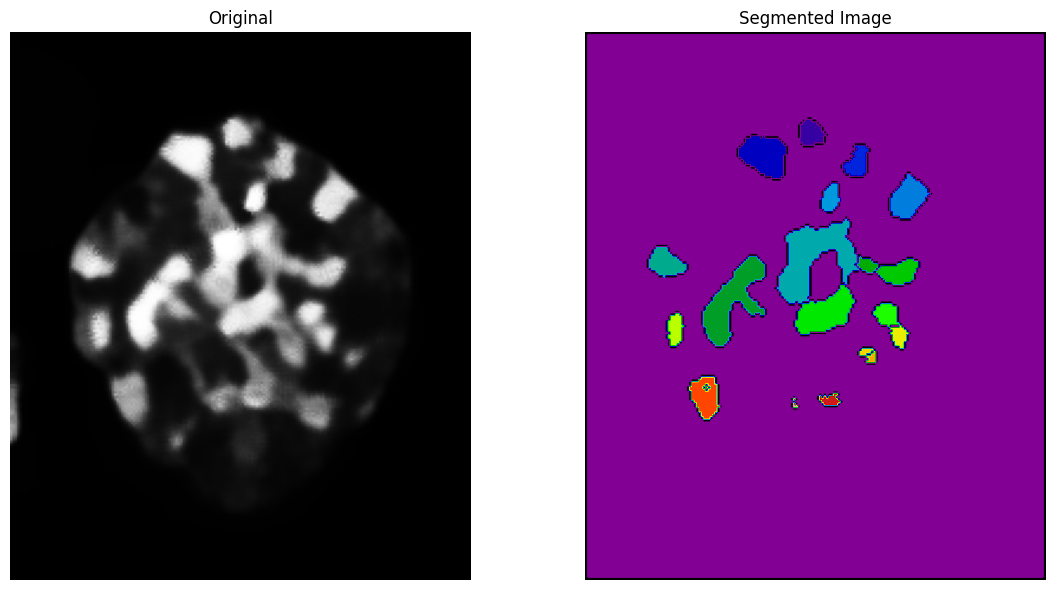

In [85]:
image = cv2.imread('example_images/expansion1.jpg', 0)
image = rescale_image(image)
image = denoise_image(image, threshold = 0.005)
image = enhance_contrast(image, method='sigmoid_correction')

# Perform the segmentation
segmented_image = segment_and_separate_blobs(image)

# Display the original and segmented images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(segmented_image, cmap='nipy_spectral') # The 'nipy_spectral' colormap will make it easier to distinguish different labels
ax[1].set_title('Segmented Image')
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [41]:
np.unique(segmented_image)

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54], dtype=int32)

In [47]:
from skimage import morphology
from scipy import ndimage
from sklearn.cluster import KMeans

from skimage.segmentation import find_boundaries
from skimage import morphology
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.measure import label
#from skimage.morphology import watershed

def segment_and_separate_blobs(image, min_region_area=50):
    # Use Canny to detect edges
    edges = cv2.Canny(image,100,200)
    
    # Use K-means clustering with 4 clusters
    pixels = image.reshape(-1, 1)
    kmeans = KMeans(n_clusters=4, random_state=0).fit(pixels)
    clustered_image = kmeans.labels_.reshape(image.shape)
    
    # Calculate cluster means
    cluster_means = kmeans.cluster_centers_.squeeze()
    
    # Get the pixel intensities corresponding to definitely and possibly DNA blobs
    unique_labels = np.unique(clustered_image)
    sorted_labels = unique_labels[np.argsort(cluster_means)]
    definitely_dna_blobs = (clustered_image == sorted_labels[-1]).astype(np.uint8)
    possibly_dna_blobs = (clustered_image == sorted_labels[-2]).astype(np.uint8)
    
    # Set sure background (everything not in definitely and possibly DNA blobs)
    sure_bg = np.logical_not(np.logical_or(definitely_dna_blobs, possibly_dna_blobs)).astype(np.uint8)

    # Distance Transform for definitely_dna_blobs
    dist_transform = cv2.distanceTransform(definitely_dna_blobs,cv2.DIST_L2,5)
    
    # Set sure foreground (definitely DNA blobs where the distance transform is greater than 0.5, for example)
    sure_fg = np.uint8(dist_transform > 0.5)
    
    # Set region of unknown (possibly DNA blobs and definitely_dna_blobs but doesn't include the sure_fg)
    unknown = ((definitely_dna_blobs + possibly_dna_blobs) > 0) & (sure_fg == 0)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 1] = 0
    
    # Convert image to BGR for watershed method
    image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Perform the watershed and update the markers image
    markers = cv2.watershed(image_bgr, markers)

    # After the watershed algorithm, split labels using the edges
    max_label = markers.max()
    for i in range(1, max_label + 1):
        # If a label is divided by strong edges, split it into multiple labels
        region = markers == i
        boundaries = find_boundaries(region)
        strong_edges = edges > 20  # adjust this threshold as needed
        split_regions = region & ~morphology.dilation(strong_edges & boundaries)
        labels, n_labels = ndimage.label(split_regions)

        # Re-assign the labels in the split region
        new_labels = labels + max_label  # offset new labels to avoid conflicts
        markers[split_regions] = new_labels[split_regions]

        # Create a border around the split region
        border = morphology.dilation(split_regions) & ~split_regions

        # Assign a unique label to the border
        markers[border] = max_label + 1

        # Update the labels of the split regions
        markers[split_regions] = labels + max_label

        # Update the maximum label number
        max_label += n_labels + 1  # also account for the new border label

    return markers


C:\Users\Kurti\anaconda3\envs\aqua\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


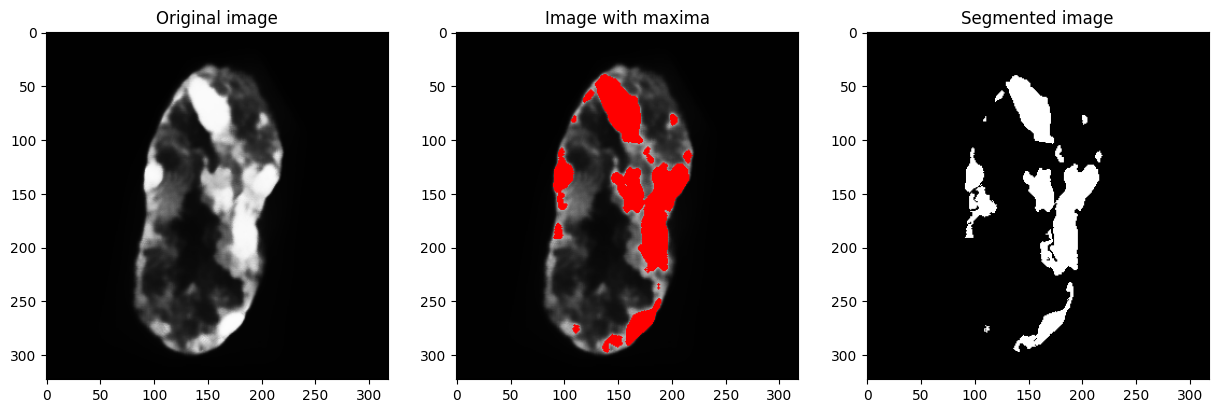

In [10]:
import numpy as np
from skimage.feature import peak_local_max
import numpy as np
from sklearn.cluster import KMeans
import cv2


def region_growing(img, seeds, sure_bg, threshold=20):
    # Initialize segmented output image
    height, width = img.shape
    segmented = np.zeros((height,width), np.uint8)

    # List to hold the pixel coordinates that need to be checked
    pixel_list = []

    # Loop through all seeds
    for seed in seeds:
        x, y = seed
        # Add each seed to pixel list
        pixel_list.append((x, y))

    # Loop until there are no pixels in the pixel list
    while len(pixel_list) > 0:
        # Pop a pixel from the list
        x, y = pixel_list.pop(0)
        intensity = img[x, y]

        # Loop through all the pixels around the current pixel
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x + dx, y + dy

                # If the new pixel is inside the image and not yet segmented
                # and the absolute difference in intensity is less than threshold
                # and the pixel is not in sure_bg
                if (0 <= nx < height and 0 <= ny < width and
                        segmented[nx, ny] == 0 and
                        abs(int(img[nx, ny]) - intensity) <= threshold and
                        sure_bg[nx, ny] == 0):
                    # Add the new pixel to the segmented image and pixel list
                    segmented[nx, ny] = 255
                    pixel_list.append((nx, ny))

    return segmented


def segment_dna_blobs(img, min_distance=10, threshold=5):
    # Use K-means clustering with 4 clusters
    pixels = img.reshape(-1, 1)
    kmeans = KMeans(n_clusters=4, random_state=0).fit(pixels)
    clustered_image = kmeans.labels_.reshape(img.shape)
    
    # Calculate cluster means
    cluster_means = kmeans.cluster_centers_.squeeze()
    
    # Get the pixel intensities corresponding to definitely and possibly DNA blobs
    unique_labels = np.unique(clustered_image)
    sorted_labels = unique_labels[np.argsort(cluster_means)]
    definitely_dna_blobs = (clustered_image == sorted_labels[-1]).astype(np.uint8)
    possibly_dna_blobs = (clustered_image == sorted_labels[-2]).astype(np.uint8)
    
    # Merge the definitely and possibly DNA blobs regions
    dna_blobs_region = definitely_dna_blobs + possibly_dna_blobs

    # Set sure background (everything not in definitely and possibly DNA blobs)
    sure_bg = np.logical_not(np.logical_or(definitely_dna_blobs, possibly_dna_blobs)).astype(np.uint8)

    # Distance Transform for definitely_dna_blobs
    dist_transform = cv2.distanceTransform(definitely_dna_blobs, cv2.DIST_L2, 5)
    
    # Set sure foreground (definitely DNA blobs where the distance transform is greater than 0.5, for example)
    sure_fg = np.uint8(dist_transform > 0.5)
    
    # Set region of unknown (possibly DNA blobs and definitely_dna_blobs but doesn't include the sure_fg)
    unknown = ((definitely_dna_blobs + possibly_dna_blobs) > 0) & (sure_fg == 0)
    
    # Use sure_fg as seeds
    seeds = np.argwhere(sure_fg == 1)

    # Perform region growing from detected seeds
    segmented = region_growing(img, seeds, sure_bg, threshold)
    
    return segmented, seeds


image = cv2.imread('example_images/expansion3.jpg', 0)
image = rescale_image(image)
image = denoise_image(image, threshold = 0.005)
image = enhance_contrast(image, method='sigmoid_correction')
img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Segment the DNA blobs
segmented, maxima = segment_dna_blobs(image)

# Display the original image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original image')

# Display the image with maxima
img_maxima = img.copy()
for y, x in maxima:
    cv2.circle(img_maxima, (x, y), 1, (255, 0, 0), -1)

plt.subplot(1, 3, 2)
plt.imshow(img_maxima, cmap='gray')
plt.title('Image with maxima')

# Display the segmented image
plt.subplot(1, 3, 3)
plt.imshow(segmented, cmap='gray')
plt.title('Segmented image')

plt.show()


C:\Users\Kurti\anaconda3\envs\aqua\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Kurti\AppData\Local\Temp\ipykernel_31600\2405379970.py:70: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  maxima = peak_local_max(img, min_distance=min_distance, labels=sure_fg, indices=True)


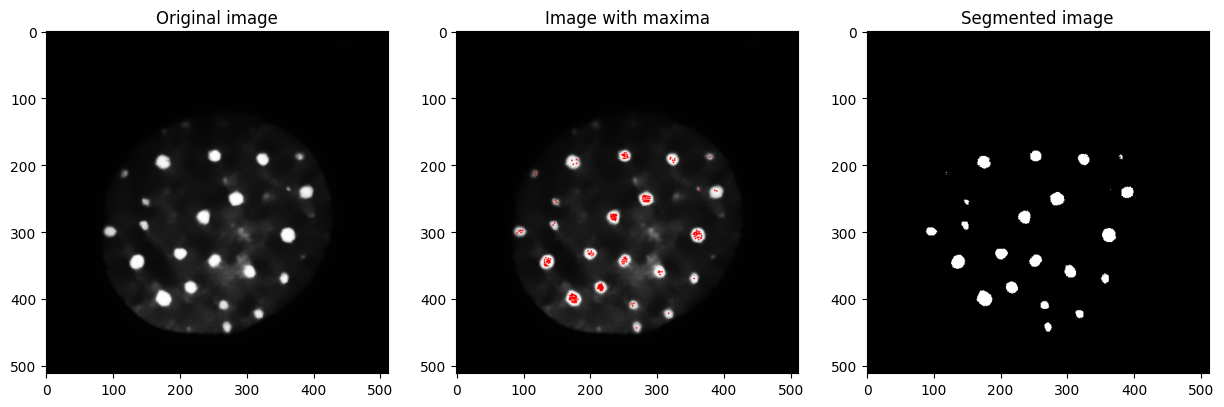

In [19]:
def region_growing(img, seeds, sure_fg, unknown, sure_bg, threshold=20):
    # Initialize segmented output image
    height, width = img.shape
    segmented = np.zeros((height,width), np.uint8)

    # List to hold the pixel coordinates that need to be checked
    pixel_list = []

    # Loop through all seeds
    for seed in seeds:
        x, y = seed
        # Add each seed to pixel list
        pixel_list.append((x, y))

    # Loop until there are no pixels in the pixel list
    while len(pixel_list) > 0:
        # Pop a pixel from the list
        x, y = pixel_list.pop(0)
        intensity = img[x, y]

        # Loop through all the pixels around the current pixel
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x + dx, y + dy

                # If the new pixel is inside the image and not yet segmented
                # and (the pixel is in sure_fg or the absolute difference in intensity is less than threshold and the pixel is in unknown)
                if (0 <= nx < height and 0 <= ny < width and
                        segmented[nx, ny] == 0 and
                        sure_bg[nx, ny] == 0 and
                        (sure_fg[nx, ny] == 1 or (abs(int(img[nx, ny]) - intensity) <= threshold and unknown[nx, ny] == 1))):
                    # Add the new pixel to the segmented image and pixel list
                    segmented[nx, ny] = 255
                    pixel_list.append((nx, ny))

    return segmented


def segment_dna_blobs(img, min_distance=2, threshold=5):
    # Use K-means clustering with 4 clusters
    pixels = image.reshape(-1, 1)
    kmeans = KMeans(n_clusters=4, random_state=0).fit(pixels)
    clustered_image = kmeans.labels_.reshape(image.shape)
    
    # Calculate cluster means
    cluster_means = kmeans.cluster_centers_.squeeze()
    
    # Get the pixel intensities corresponding to definitely and possibly DNA blobs
    unique_labels = np.unique(clustered_image)
    sorted_labels = unique_labels[np.argsort(cluster_means)]
    definitely_dna_blobs = (clustered_image == sorted_labels[-1]).astype(np.uint8)
    possibly_dna_blobs = (clustered_image == sorted_labels[-2]).astype(np.uint8)
    
    # Merge the definitely and possibly DNA blobs regions
    dna_blobs_region = definitely_dna_blobs + possibly_dna_blobs

    # Set sure background (everything not in definitely and possibly DNA blobs)
    sure_bg = np.logical_not(np.logical_or(definitely_dna_blobs, possibly_dna_blobs)).astype(np.uint8)

    # Distance Transform for definitely_dna_blobs
    dist_transform = cv2.distanceTransform(definitely_dna_blobs,cv2.DIST_L2,5)
    
    # Set sure foreground (definitely DNA blobs where the distance transform is greater than 0.5, for example)
    sure_fg = np.uint8(dist_transform > 0.5)
    
    # Set region of unknown (possibly DNA blobs and definitely_dna_blobs but doesn't include the sure_fg)
    unknown = ((definitely_dna_blobs + possibly_dna_blobs) > 0) & (sure_fg == 0)
    
    # Detect local maxima in the DNA blobs regions
    maxima = peak_local_max(img, min_distance=min_distance, labels=sure_fg, indices=True)
    
    # Convert maxima coordinates to tuples
    seeds = [tuple(x) for x in maxima]

    # Perform region growing from detected seeds
    segmented = region_growing(img, seeds, sure_fg, unknown, sure_bg, threshold)

    return segmented, maxima

image = cv2.imread('example_images/ex111.tif', 0)
image = rescale_image(image)
image = denoise_image(image, threshold = 0.005)
image = enhance_contrast(image, method='sigmoid_correction')
img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Segment the DNA blobs
segmented, maxima = segment_dna_blobs(image)

# Display the original image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original image')

# Display the image with maxima
img_maxima = img.copy()
for y, x in maxima:
    cv2.circle(img_maxima, (x, y), 1, (255, 0, 0), -1)

plt.subplot(1, 3, 2)
plt.imshow(img_maxima, cmap='gray')
plt.title('Image with maxima')

# Display the segmented image
plt.subplot(1, 3, 3)
plt.imshow(segmented, cmap='gray')
plt.title('Segmented image')

plt.show()